In [1]:
import sys
import re
import datetime
from math import log
import csv
import pprint
import math
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from elasticsearch import Elasticsearch, helpers

from __future__ import division

%matplotlib inline

np.set_printoptions(threshold=1000)
pd.set_option('display.max_rows', 100)

pp = pprint.PrettyPrinter()

/cvmfs/sft.cern.ch/lcg/views/LCG_91/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#es = Elasticsearch([{'host': 'hcc-metrics.unl.edu', 'port': 9200}])
username = 'cms'
password = 'B3A96-D0g_PkkPz5'
es = Elasticsearch([{'host': 'es-cms.cern.ch', 'port': 9203, 'http_auth': username+':'+password}], use_ssl=True,verify_certs=True,ca_certs="ca-bundle.trust.crt")

In [28]:
indices = es.cat.indices(index="cms-test2-20*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']

In [29]:
indices

[u'cms-test2-2017-11-01',
 u'cms-test2-2017-11-05',
 u'cms-test2-2017-11-06',
 u'cms-test2-2017-11-07']

In [31]:
def time_filter(indices, days=0, until=0):
    if days == 0:
        return ["cms-test*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'cms-test2-', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if until <= diff.days < days + until:
            filtered.append(i.rstrip())
    return filtered

In [32]:
# Change second argument to use a different time range for ES queries
no_of_days = 25   # how many days to consider
last_day = 0   # how many days was the last day to consider
# example: no_of_days = 20, last_day = 10 means: use 20 days, up to 10 days ago
ind = time_filter(indices, no_of_days, last_day)
ind = ','.join(ind)

In [33]:
ind

u'cms-test2-2017-11-01,cms-test2-2017-11-05,cms-test2-2017-11-06,cms-test2-2017-11-07'

These variables are used:
* **RequestCpus**: number of cores used by the job. It is always defined
* **CpuTimeHr**: CPU time used by the job (system+user), not the one reported by cmsRun (hours). It is always defined. It includes failed attempts. **It must be > 0**
* **CoreHr**: *RemoteWallClockTime* times *RequestCpus*. It includes time spent in failed attempts. It is always defined. **It must be > 0**
* **WallClockHr**: same as *RemoteWallClockTime* but in hourswall-clock time used by the job (hours), not just on cmsRun. It is always defined
* **CpuEff**: CPU efficiency of the whole job (not just cmsRun), including failed attempts. The same as *CpuTimeHr*/(*WallClockHr* x *RequestCpus*) (%). It is always defined. **It must be <= 100**
* **Type**: type of job (production or analysis). It is always defined
* **Status**: job status (completed, running, idle, removed, held). **It must be 'completed'**
* **ExitCode**: it is the same as *Chirp_WMCore_cmsRun_ExitCode*. It is defined if and only if _Status_ is *completed*. **It must exist**
* **TaskType**: it is either analysis, or it is derived from *WMAgent_TaskType* (production, merge, digireco, repack, reco, cleanup, logcollect, miniaod, express, dataprocessing, gensim, etc.). It is always defined
* **Site**: site assigned to the job. It is always defined
* **Workflow**: workflow name. Derived either from *CRAB_Workflow* or from *WMAgent_RequestName*
* **WMAgent_SubTaskName**: subtask name for production jobs, used as "task identifier". Defined for 99% of the core-hours of the production jobs
* **CRAB_Workflow**: task name for an analysis job. Defined for 98.5% of the core-hours of the analysis jobs


In [34]:
# Query for production jobs

s1 = {
    "size": 0,
    "query": {
        "bool": {
            "filter": [
                {
                    "match": {
                        "Type": "production"
                    }
                },
                {
                    "exists": {
                        "field": "ExitCode"
                    }
                },
                {
                    "match": {
                        "Status": "Completed"   # de facto equivalent to ExitCode existing
                    }
                }
            ]
        }
    },
    "aggs": {
        "ttypes": {
            "terms": {
                "field": "TaskType",
                "size": 1000
            },
            "aggs": {
                "site": {
                    "terms": {
                        "field": "Site",
                        "size": 1000
                    },
                    "aggs": {
                        "wf": {
                            "terms": {
                                "field": "WMAgent_SubTaskName",
                                "size": 100000
                            },
                            "aggs": {
                                "type": {
                                    "terms": {
                                        "field": "Type",
                                        "size": 10
                                    },
                                    "aggs": {
                                        "exitcode": {
                                            "terms": {
                                                "field": "ExitCode",
                                                "size": 1000
                                            },
                                            "aggs": {
                                                "loc": {
                                                    "terms": {
                                                        "field": "InputData",
                                                        "size": 1000
                                                    },
                                                    "aggs": {
                                                        "3": {
                                                            "stats": {
                                                                "field": "CpuTimeHr"
                                                            }
                                                        },
                                                        "4": {
                                                            "stats": {
                                                                "field": "CommittedCoreHr"
                                                            }
                                                        },
                                                        "5": {
                                                            "stats": {
                                                                "field": "CoreHr"
                                                            }
                                                        },
                                                        "6": {
                                                            "avg": {
                                                                "field": "RequestCpus"
                                                            }
                                                        },
                                                        "8": {
                                                            "avg": {
                                                                "field": "CpuEff"
                                                            }
                                                        },
                                                        "16": {
                                                            "avg": {
                                                                "field": "CompletionDate"
                                                            }
                                                        },
                                                        "17": {
                                                            "stats": {
                                                                "field": "RemoteWallClockTime"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}

res1 = es.search(index=ind, body=s1, request_timeout=12000)

In [35]:
# Query for analysis jobs

s2 = {
    "size": 0,
    "query": {
        "bool": {
            "filter": [
                {
                    "match": {
                        "Type": "analysis"
                    }
                },
                {
                    "exists": {
                        "field": "ExitCode"
                    }
                },
                {
                    "match": {
                        "Status": "Completed"
                    }
                }
            ]
        }
    },
    "aggs": {
        "ttypes": {
            "terms": {
                "field": "TaskType",
                "size": 1000
            },
            "aggs": {
                "site": {
                    "terms": {
                        "field": "Site",
                        "size": 1000
                    },
                    "aggs": {
                        "wf": {
                            "terms": {
                                "field": "CRAB_Workflow",
                                "size": 100000
                            },
                            "aggs": {
                                "type": {
                                    "terms": {
                                        "field": "Type",
                                        "size": 10
                                    },
                                    "aggs": {
                                        "exitcode": {
                                            "terms": {
                                                "field": "ExitCode",
                                                "size": 1000
                                            },
                                            "aggs": {
                                                "loc": {
                                                    "terms": {
                                                        "field": "InputData",
                                                        "size": 1000
                                                    },
                                                    "aggs": {
                                                        "3": {
                                                            "stats": {
                                                                "field": "CpuTimeHr"
                                                            }
                                                        },
                                                        "4": {
                                                            "stats": {
                                                                "field": "CommittedCoreHr"
                                                            }
                                                        },
                                                        "5": {
                                                            "stats": {
                                                                "field": "CoreHr"
                                                            }
                                                        },
                                                        "6": {
                                                            "avg": {
                                                                "field": "RequestCpus"
                                                            }
                                                        },
                                                        "8": {
                                                            "avg": {
                                                                "field": "CpuEff"
                                                            }
                                                        },
                                                        "16": {
                                                            "avg": {
                                                                "field": "CompletionDate"
                                                            }
                                                        },
                                                        "17": {
                                                            "stats": {
                                                                "field": "RemoteWallClockTime"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}

res2 = es.search(index=ind, body=s2, request_timeout=12000)

In [36]:
output_file = 'task_cms_ineff_test.csv'

In [37]:
names = ['task', 'tasktype', 'site', 'type', 'exitcode', 'locality', 'njobs',
         'cpu', 'cpu_avg', 'cwc', 'cwc_avg', 'wc', 'wc_avg', 'cores', 'eff',
         'date', 'rwct', 'rwct_avg']

with open(output_file, 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(names)
    for res in (res1, res2):
        buckets1 = res['aggregations']['ttypes']['buckets']
        for b1 in buckets1:
            ttype = b1['key']
            buckets2 = b1['site']['buckets']
            for b2 in buckets2:
                site = b2['key']
                buckets3 = b2['wf']['buckets']
                for b3 in buckets3:
                    wf = b3['key']
                    buckets4 = b3['type']['buckets']
                    for b4 in buckets4:
                        typ = b4['key']
                        buckets5 = b4['exitcode']['buckets']
                        for b5 in buckets5:
                            exitcode = b5['key']
                            buckets6 = b5['loc']['buckets']
                            for b6 in buckets6:
                                loc = b6['key']
                                cnt = b6['doc_count']
                                writer.writerow([
                                    wf,
                                    ttype,
                                    site,
                                    typ,
                                    exitcode,
                                    loc,
                                    cnt,
                                    b6['3']['sum'] * 3600.,     # total CPU time (seconds)
                                    b6['3']['avg'] * 3600.,     # average CPU time (seconds)
                                    b6['4']['sum'] * 3600.,     # total committed wall-clock time times cores (seconds)                                        b6['4']['avg'] * 3600.,     # average wall-clock time times cores (seconds)
                                    b6['4']['avg'] * 3600.,     # average committed wall-clock time times cores (seconds)                                        b6['4']['avg'] * 3600.,     # average wall-clock time times cores (seconds)
                                    b6['5']['sum'] * 3600.,     # total wall-clock time times cores (seconds)
                                    b6['5']['avg'] * 3600.,     # average wall-clock time times cores (seconds)
                                    b6['6']['value'],           # cores
                                    b6['8']['value'],           # CPU efficiency (%)
                                    b6['16']['value'],          # date
                                    b6['17']['sum'],            # total wall-clock time (seconds)
                                    b6['17']['avg']             # average job duration (seconds)
                                ])


In [38]:
input_file = 'task_cms_ineff_test.csv'

In [39]:
df = pd.read_csv(input_file, dtype={'cpu_n': 'float'}, low_memory=True)

In [40]:
df[:10]

,task,tasktype,site,type,exitcode,locality,njobs,cpu,cpu_avg,cwc,cwc_avg,wc,wc_avg,cores,eff,date,rwct,rwct_avg
0,171105_083524:vmariani_crab_DPS_DoubleD0_gen22,Analysis,T2_ES_IFCA,analysis,0,Onsite,57,604668.000126,10608.210529,635177.998924,11143.473665,642280.000877,11268.070191,1.0,94.699787,1.510058e+12,642280.0,11268.070175
1,171106_162622:jfernan_crab_PowhegTuneT4hdamp_P...,Analysis,T2_ES_IFCA,analysis,50,Onsite,40,3.000000,0.075000,2854.999991,71.375000,3917.999992,97.950000,1.0,0.096277,1.510058e+12,3918.0,97.950000
2,171105_234821:mcremone_crab_JetHTRun2016B_03Fe...,Analysis,T2_US_UCSD,analysis,0,Offsite,25,125582.999969,5023.319999,149161.000156,5966.440006,149202.000618,5968.080025,1.0,83.775988,1.510058e+12,149202.0,5968.080000
3,171104_140645:wehuang_crab_crab_ExcitedBc_G_V1...,Analysis,T2_US_UCSD,analysis,0,Offsite,20,692387.000656,34619.350033,722306.002808,36115.300140,722470.004654,36123.500233,1.0,95.852776,1.510058e+12,722470.0,36123.500000
4,171104_140645:wehuang_crab_crab_ExcitedBc_G_V1...,Analysis,T2_US_UCSD,analysis,92,Offsite,1,3764.000130,3764.000130,4565.999937,4565.999937,4566.999865,4566.999865,1.0,82.417343,1.510057e+12,4567.0,4567.000000
5,171107_065708:dalfonso_crab_ZZTo2Q2Nu_13TeV_am...,Analysis,T2_US_UCSD,analysis,0,Offsite,13,216556.000900,16658.153915,222721.999454,17132.461496,222729.998016,17133.076770,1.0,97.078290,1.510058e+12,222730.0,17133.076923
6,171106_162622:jfernan_crab_PowhegTuneT4hdamp_P...,Analysis,T2_US_UCSD,analysis,0,Onsite,7,1454.000026,207.714289,2903.000012,414.714287,2906.000009,415.142858,1.0,54.244154,1.510059e+12,2906.0,415.142857
7,171107_013518:asparker_crab_QJMtreeV2_SingleMu...,Analysis,T2_US_UCSD,analysis,0,Offsite,6,109694.999886,18282.499981,115089.997673,19181.666279,117529.999352,19588.333225,1.0,93.650042,1.510058e+12,117530.0,19588.333333
8,171107_070453:dalfonso_crab_WZTo3LNu_TuneCUETP...,Analysis,T2_US_UCSD,analysis,0,Offsite,5,81150.999355,16230.199871,83274.001265,16654.800253,83278.000116,16655.600023,1.0,97.443138,1.510058e+12,83278.0,16655.600000
9,171106_162622:jfernan_crab_PowhegTuneT4hdamp_P...,Analysis,T2_RU_IHEP,analysis,50,Onsite,65,0.000000,0.000000,4660.999972,71.707692,5410.999981,83.246154,1.0,0.000000,1.510058e+12,5411.0,83.246154


In [40]:
x = np.array(df['task'].values, dtype='string')

df['premix'] = np.core.defchararray.find(x, 'premix') >= 0
df['hi'] = np.core.defchararray.find(x, 'hin') >= 0

### Remove unwanted tasks

In [41]:
cp_pre = df['cpu'].sum()
wc_pre = df['wc'].sum()

In [42]:

df = df[np.core.defchararray.find(list(df.site), 't3') == -1].copy()   # remove "test" jobs
#df = df[np.core.defchararray.find(list(df.task), 'test') == -1].copy()   # remove "test" jobs
#df = df[df.exitcode == 0].copy()   # remove failed jobs
#df = df[df.hi == False].copy()   # heavy ions jobs
#df = df[df.eff <= 100].copy()   # remove jobs with wrong CPU efficiency (now it should be redundant)
df = df[df.site != 't3_us_osg'].copy()
df = df[df.site != 't3_us_nersc'].copy()

wc_post = df['wc'].sum()
cp_post = df['cpu'].sum()

print 'Removed %.2f %% of core-hours' % ((wc_pre - wc_post) / wc_pre * 100.)
print 'Removed %.2f %% of CPU hours' % ((cp_pre - cp_post) / cp_pre * 100.)

TypeError: string operation on non-string array

In [43]:
df

,task,tasktype,site,type,exitcode,locality,njobs,cpu,cpu_avg,cwc,cwc_avg,wc,wc_avg,cores,eff,date,rwct,rwct_avg,premix,hi


In [17]:
print wc_pre / 3600.
print cp_pre / 3600.

79693430.8114
54171286.4789


In [18]:
print wc_post / 3600.
print cp_post / 3600.

77616887.575
52913404.9369


In [19]:
df.sort_values('site', ascending=True)[:5]

,task,tasktype,site,type,exitcode,locality,njobs,cpu,cpu_avg,cwc,cwc_avg,wc,wc_avg,cores,eff,date,rwct,rwct_avg,premix,hi
37147,/promptreco_run301665_zerobias5/reco/alcaskim/...,merge,t0_ch_cern,production,0,Onsite,1,1.0,1.0,24.0,24.0,24.0,24.0,1.0,4.166667,1.503740e+12,24.0,24.0,False,False
44131,/promptreco_run301907_minimumbias/reco/recomer...,merge,t0_ch_cern,production,0,Onsite,1,4603.0,4603.0,4963.0,4963.0,4963.0,4963.0,1.0,92.746323,1.503929e+12,4963.0,4963.0,False,False
44132,/promptreco_run301907_minimumbias/reco/recomer...,merge,t0_ch_cern,production,0,Onsite,1,0.0,0.0,10.0,10.0,10.0,10.0,1.0,0.000000,1.503996e+12,10.0,10.0,False,False
44133,/promptreco_run301907_minimumbias/reco/recomer...,merge,t0_ch_cern,production,0,Onsite,1,33.0,33.0,112.0,112.0,112.0,112.0,1.0,29.464286,1.503924e+12,112.0,112.0,False,False
44134,/promptreco_run301907_minimumbias/reco/recomer...,merge,t0_ch_cern,production,0,Onsite,1,238.0,238.0,295.0,295.0,295.0,295.0,1.0,80.677966,1.503925e+12,295.0,295.0,False,False


In [20]:
df['wc'].sum() / 3600.

77616887.575000003

The wallclock time recorded by EGI is 1.36 times the total payload time in ES.

## Preliminary data exploration

In [96]:
grouped = df.groupby(['tasktype'], as_index=False)
a = grouped.agg({'task': 'nunique', # ok!
                 'wc': 'sum',             # ok!
                 'eff': 'mean',         # wrong!
                 'cores': 'mean',         # wrong!
                 'njobs': 'sum',          # ok!
                })
a.sort_values('wc', ascending=False, inplace=True)
a[:20]

,tasktype,cores,task,wc,eff,njobs
17,analysis,1.112221,403640,1.004616e+12,69.734775,136891724
231,gensim,1.195995,12437,9.042370e+11,79.055524,38111778
35,digi,3.897662,17342,4.371012e+11,60.641182,28077674
387,reco,4.562362,64998,3.590133e+11,68.514717,25428486
34,dataprocessing,4.003815,1915,2.571008e+11,57.245387,5787512
96,digireco,3.679196,4368,1.523578e+11,50.325300,8156994
304,miniaod,3.941105,20333,3.550540e+10,68.483234,4131772
273,lhe,1.000000,113,2.973752e+10,74.393070,864204
276,merge,1.000000,967405,2.033692e+10,19.876993,13002665
189,express,5.493154,6229,8.081082e+09,30.395100,1209223


## Average CPU efficiency of tasks

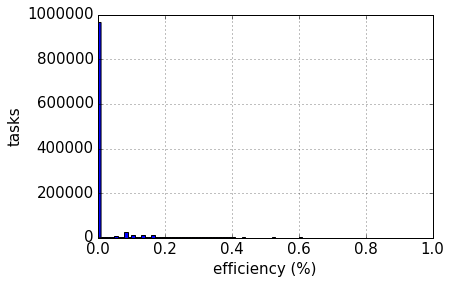

In [102]:
grouped = df.groupby(['task'], as_index=False)
a = grouped['eff'].mean()
fig = a['eff'].hist(bins=100, log=False, range=(0, 1))   # NOT VERY CORRECT (arithmetic mean of efficiencies...)
plt.xlabel('efficiency (%)')
plt.ylabel('tasks')

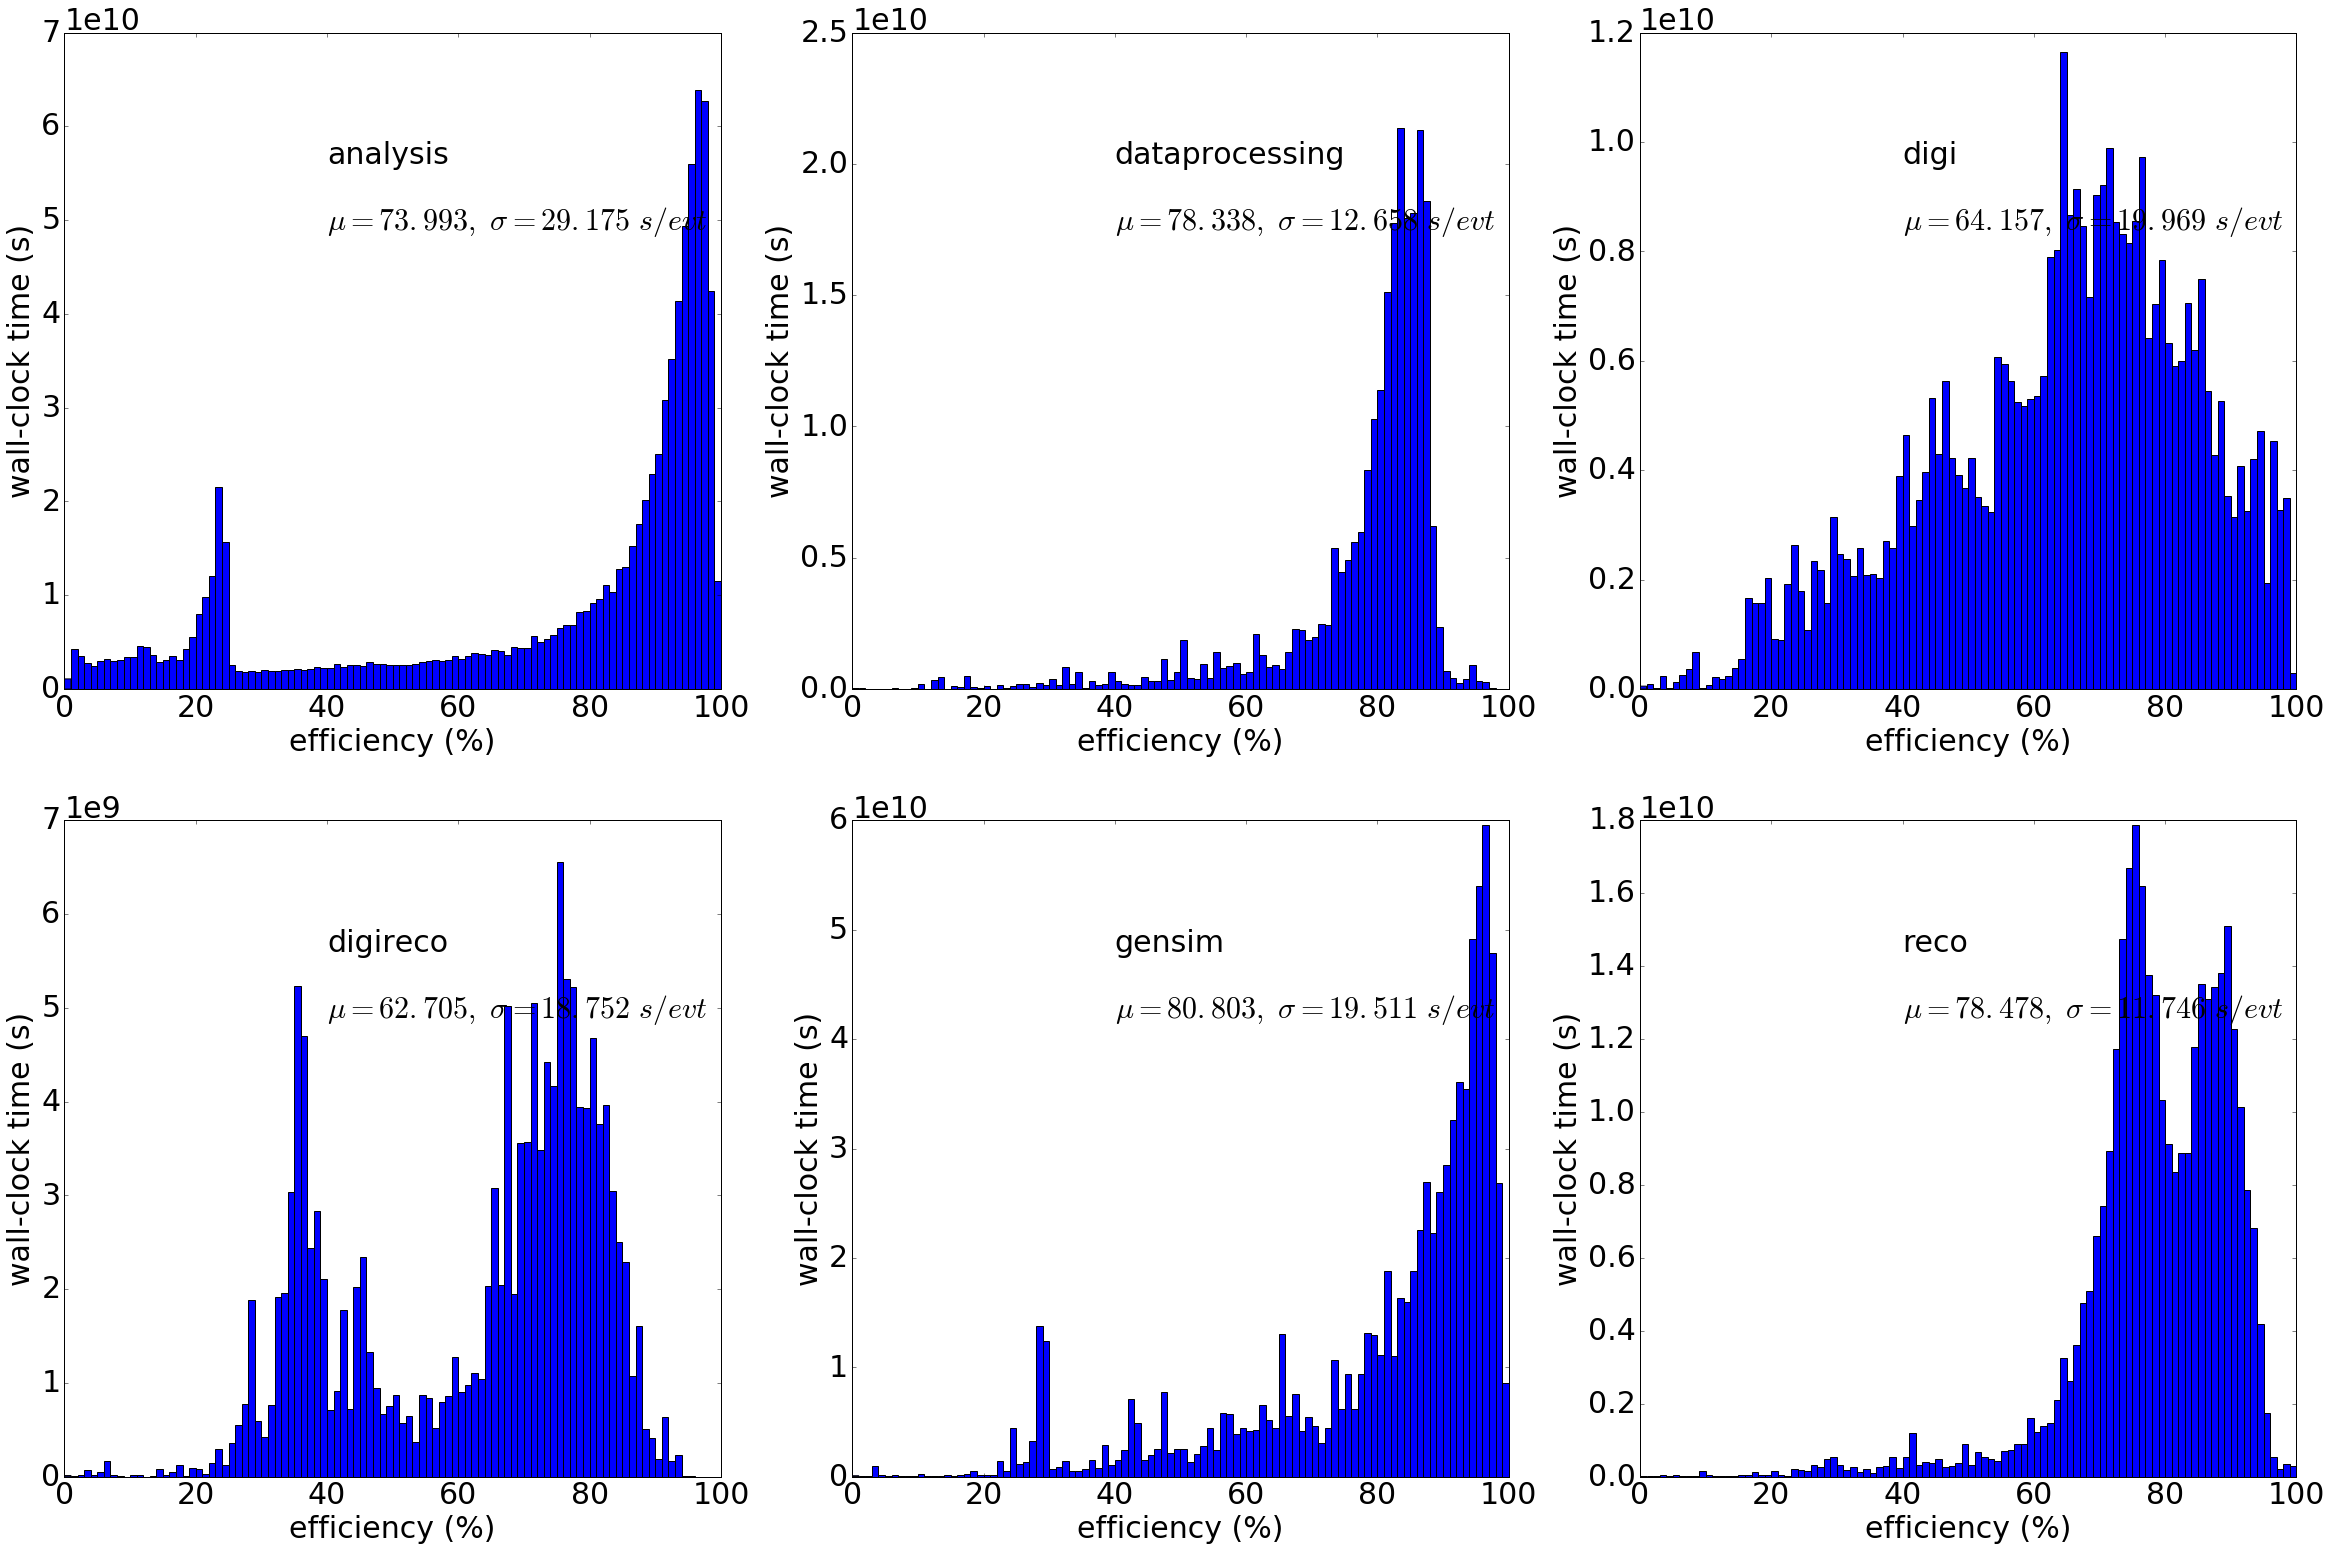

In [11]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'eff'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['tasktype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.02 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., 100.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('efficiency (%)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f\ s/evt$' % (mean, std)
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
    else:
        plt.text(t_x(.4), t_y(.8), p)
        plt.text(t_x(.4), t_y(.7), stats)
    i += 1

In [49]:
grouped = df.groupby(['tasktype', 'locality', 'premix'], as_index=False)

In [13]:
a = grouped.agg({'wc': np.sum})

In [55]:
types = ['gensim', 'digi', 'reco', 'digireco', 'analysis']

In [56]:
a = grouped.agg({
                 'cpu': 'sum',
                 'cwc': 'sum',
                 'wc': 'sum'
                })

In [69]:
b = a[a.tasktype.isin(types)].copy()
b['ineff'] = b['cwc'] - b['cpu']

In [70]:
b

,tasktype,locality,premix,cwc,wc,cpu,ineff
17,analysis,Offsite,False,2.207185e+11,2.335275e+11,1.513628e+11,6.935575e+10
18,analysis,Offsite,True,1.748536e+08,1.873047e+08,1.201865e+08,5.466711e+07
19,analysis,Onsite,False,6.092120e+11,6.494432e+11,4.837355e+11,1.254765e+11
20,analysis,Onsite,True,7.068409e+07,7.601060e+07,6.764326e+07,3.040832e+06
40,digi,Offsite,False,6.559338e+10,6.973620e+10,4.082305e+10,2.477033e+10
41,digi,Offsite,True,5.446000e+10,5.860173e+10,3.205723e+10,2.240277e+10
42,digi,Onsite,False,1.629355e+11,1.740011e+11,1.097617e+11,5.317377e+10
43,digi,Onsite,True,9.126752e+10,9.645270e+10,6.185669e+10,2.941083e+10
100,digireco,Offsite,False,1.745520e+10,1.843797e+10,1.161766e+10,5.837538e+09
101,digireco,Offsite,True,3.306992e+10,3.472557e+10,2.199308e+10,1.107685e+10


In [78]:
df['wc'].sum()

2962403058987.001

In [15]:
t_wc = dict()
t_twc = dict()
t_cpu = dict()
t_ineff = dict()
for t in types:
    g = grouped.get_group(t)
    t_cpu[t] = g['cpu'].sum() / 3600. / 1e6
    t_wc[t] = g['wc'].sum() / 3600. / 1e6
    t_twc[t] = g['twc'].sum() / 3600. / 1e6
    t_ineff[t] = (g['wc'] - g['cpu']).sum()  / 3600. / 1e6
ineff_data = pd.DataFrame({'twc': t_twc, 'wc': t_wc, 'cpu': t_cpu, 'ineff': t_ineff}, index=types)

ValueError: must supply a tuple to get_group with multiple grouping keys

In [ ]:
ineff_data

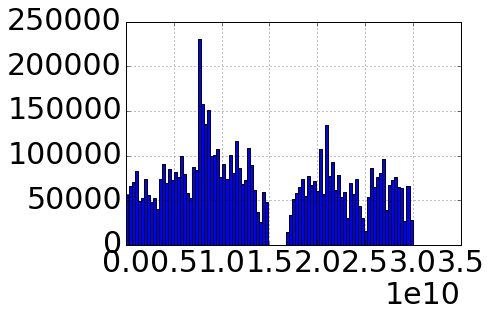

In [75]:
times = df['date'] - 1475280000000
times.hist(range=[0., 31536000000], bins=100)

In [7]:
print df['date'].min()
print df['date'].max()

1.47289091275e+12
1.505121855e+12


In [84]:
df[df['site'] == 't2_us_mit']['wc'].sum()

117486880899.0